# Proyecto de Colorización de Imagenes

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from IPython.display import clear_output
from tqdm.notebook import tqdm

## Creación de imagenes en ByN

In [ ]:
%cd /content/drive/MyDrive/Colorizing/Dataset/target

/content/drive/MyDrive/Colorizing/Dataset/target


In [ ]:
from PIL import Image 

path_target = "/content/drive/MyDrive/Colorizing/Dataset/target/"
path_train = "/content/drive/MyDrive/Colorizing/Dataset/train/"
imgurls = !ls -1 {path_target}
for image in tqdm(imgurls):
  try:
    img = PIL.Image.open(path_target + image)
    img = img.convert('L')
    img.save(path_train + image)
  except:
    pass



In [ ]:
%cd /content/drive/MyDrive/Colorizing

/content/drive/MyDrive/Colorizing


In [ ]:
#Blanco y negro
path_train = "/content/drive/MyDrive/Colorizing/Dataset/train/"
imgurls = !ls -1 {path_train}
for image in tqdm(imgurls):
  img = PIL.Image.open(path_train + image)
  img = img.convert(mode='RGB')
  img.save(path_train + image)

## Inicialización de **Paths**

In [ ]:
##Directorio

#Blanco y negro
path_train = "/content/drive/MyDrive/Colorizing/Dataset/train/"
#A color
path_target = "/content/drive/MyDrive/Colorizing/Dataset/target/"
#Avances
checkpoint_folder = "/content/drive/MyDrive/Colorizing/checkpoints/"

imgurls = !ls -1 {path_train}
print(imgurls[:100])

['0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg', '0007.jpg', '0008.jpg', '0010.jpg', '0011.jpg', '0013.jpg', '0014.jpg', '0015.jpg', '0016.jpg', '0018.jpg', '0019.jpg', '0020.jpg', '0021.jpg', '0022.jpg', '0023.jpg', '0024.jpg', '0026.jpg', '0027.jpg', '0028.jpg', '0029.jpg', '0030.jpg', '0031.jpg', '0032.jpg', '0033.jpg', '0034.jpg', '0035.jpg', '0036.jpg', '0037.jpg', '0038.jpg', '0040.jpg', '0042.jpg', '0043.jpg', '0044.jpg', '0045.jpg', '0046.jpg', '0047.jpg', '0048.jpg', '0049.jpg', '0051.jpg', '0052.jpg', '0053.jpg', '0054.jpg', '0055.jpg', '0056.jpg', '0057.jpg', '0058.jpg', '0059.jpg', '0060.jpg', '0061.jpg', '0062.jpg', '0063.jpg', '0064.jpg', '0065.jpg', '0066.jpg', '0067.jpg', '0068.jpg', '0069.jpg', '0070.jpg', '0071.jpg', '0072.jpg', '0073.jpg', '0074.jpg', '0076.jpg', '0077.jpg', '0078.jpg', '0079.jpg', '0081.jpg', '0082.jpg', '0083.jpg', '0084.jpg', '0085.jpg', '0086.jpg', '0087.jpg', '0089.jpg', '0090.jpg', '0091.jpg', '0092.jpg', '0093.jpg', '0094.jpg', '00

 Dividimos el Dataset entre **Train** y **Test** siendo una relacion de 80% a 20%

In [ ]:
##Dividir test y entramiento
cantidad_de_imagenes = len(imgurls)
print(f"La cantidad de imagenes totales son {cantidad_de_imagenes}")
train_percentage = 0.8
train_urls = imgurls[:int(train_percentage*cantidad_de_imagenes)]
test_urls = imgurls[int(train_percentage*cantidad_de_imagenes)+1:]
print(f"La cantidad de imagenes en train son {len(train_urls)} y en test {len(test_urls)} ")

La cantidad de imagenes totales son 2032
La cantidad de imagenes en train son 1625 y en test 406 


## Data augmentation

Generamos el código que nos permitirá realizar Data Augmentation, donde nos basaremos en 3 funciones mencionadas en el paper de Pix2Pix:



*   Random Jitter que amplia la imagen a 572x572 y recorta un pedazo aleatorio de 512x512
*   Flip una parte de la función random Jitter que espeja (o no) la imagen dependiendo de una variable aleatoria.



In [ ]:
##Data augmentation
img_size = 512

#Reescalar imagen
@tf.function
def resize(input_img, tar_img, img_size):
    input_img = tf.image.resize(input_img, [img_size, img_size])
    tar_img = tf.image.resize(tar_img, [img_size, img_size])
    
    return input_img, tar_img

#Normaliza las imagenes
def normalize(input_img, tar_img):
    input_img = (input_img/255.) - 1
    tar_img = (tar_img/255.) - 1
    return input_img, tar_img

def random_jitter(input_img, tar_img):
    input_img, tar_img = resize(input_img, tar_img, 572)

    #Apila las imagenes
    stacked_image = tf.stack([input_img, tar_img], axis=0)
    #Recorta
    cropped_image = tf.image.random_crop(stacked_image, size=[2, img_size, img_size, 3])
    
    input_img, tar_img = cropped_image[0], cropped_image[1]
    if tf.random.uniform(()) > 0.5:
        input_img = tf.image.flip_left_right(input_img)
        tar_img = tf.image.flip_left_right(tar_img)
    return input_img, tar_img

## Cargado de imagenes

Definimos las funciones que cargan las imagenes

In [ ]:
def load_image(filename, augment=True):
    input_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(path_train + filename)), tf.float32)[..., :3]
    tar_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(path_target + filename)), tf.float32)[..., :3]
    input_img, tar_img = resize(input_img, tar_img, img_size)
    if augment:
        input_img, tar_img = random_jitter(input_img, tar_img)
  
    input_img, tar_img = normalize(input_img, tar_img)
    return input_img, tar_img


##Funcion para cargar las imagenes para train y test
def load_train_image(filename):
    return load_image(filename)

def load_test_image(filename):
    return load_image(filename, False)

Ahora vamos a mostrar como es una imagen del Train Set

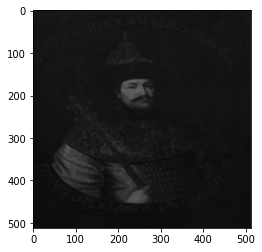

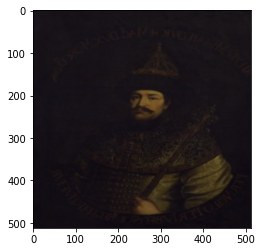

In [ ]:
plt.figure()
plt.imshow(((load_train_image(train_urls[0])[0]) + 1. ) / 2.);
plt.figure()
plt.imshow(((load_train_image(train_urls[0])[1]) + 1. ) / 2.);

## Creación de dataset

Creamos el Dataset con los nombres de las imagenes previamente seleccionadas

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_urls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(test_urls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

## Creación del modelo

Ahora procederemos a crear el modelo con las funciones downsample y upsample que se explican en el informe.

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model

def downsample(filters, batch_norm=True):
  
  result = Sequential()
  initializer = tf.random_normal_initializer(0, 0.02)
  
  #Conv
  result.add(Conv2D(filters=filters,strides=2, kernel_size=4, padding='same',
                    kernel_initializer=initializer, use_bias=not batch_norm))
  #Batch
  if batch_norm:
    result.add(BatchNormalization())
  #Activation LeakyRelu
  result.add(LeakyReLU())
  return result

def upsample(filters, dropout=True):
  result = Sequential()
  initializer = tf.random_normal_initializer(0, 0.02)
  
  #Conv
  result.add(Conv2DTranspose(filters=filters,strides=2, kernel_size=4, padding='same',
                             kernel_initializer=initializer, use_bias=False))
  #Batch
  if dropout:
    result.add(Dropout(0.5))
  #Activation LeakyRelu
  result.add(ReLU())
  return result


def Generator():
  
  initializer = tf.random_normal_initializer(0, 0.02)
  
  inputs = Input(shape=[None, None, 3]) # (b, 256, 256, 64)
  
  down_stack = [
      downsample(64, batch_norm=False), # (b, 128, 128, 64)
      downsample(128), # (b, 64, 64, 128)
      downsample(256), # (b, 32, 32, 256)
      downsample(512), # (b, 16, 16, 512)
      downsample(512), # (b, 8, 8, 512)
      downsample(512), # (b, 4, 4, 512)
      downsample(512), # (b, 2, 2, 512)
      downsample(512)  # (b, 1, 1, 512)
  ]
  
  up_stack = [
      upsample(512), # (b, 2, 2, 1024)
      upsample(512), # (b, 4, 4, 1024)
      upsample(512), # (b, 8, 8, 1024)
      upsample(512, dropout=False), # (b, 16, 16, 1024)
      upsample(256, dropout=False), # (b, 32, 32, 512)
      upsample(128, dropout=False), # (b, 64, 64, 256)
      upsample(64, dropout=False), # (b, 128, 128, 128)

  ]

  last = Conv2DTranspose(filters=3, kernel_size=4, strides=2, padding="same", kernel_initializer=initializer, 
                         activation='tanh')

  x = inputs
  s = []
  concat = Concatenate()
  for enc in down_stack:
    x = enc(x)
    s.append(x)
  s = reversed(s[:-1])
    
  for dec, sk in zip(up_stack, s):
    x = dec(x)
    x = concat([x, sk])    
 
  output = last(x)
  
  return Model(inputs=inputs, outputs=output)


def Discriminator():
  real_input = Input(shape=[None, None, 3], name="real_image")
  fake_input = Input(shape=[None, None, 3], name="fake_image")
  
  con = concatenate([real_input, fake_input])
  
  initializer = tf.random_normal_initializer(0, 0.02)
  
  dec1 = downsample(64, batch_norm=False)(con)
  dec2 = downsample(128)(dec1)
  dec3 = downsample(128)(dec2)
  dec4 = downsample(128)(dec3)
  
  output = Conv2D(filters=1, kernel_size=4, strides=1, kernel_initializer=initializer, padding='same')(dec4)
  return Model(inputs=[real_input, fake_input], outputs=output)

## Creación de checkpoint y incializacion del modelo

Generamos los optimizadores como Adam como los define el paper y procedemos a inicializar o cargar previos checkpoints de modelos guardados para no tenes que hacer el entrenamiento reiteradas veces. Tenes en cuenta que 25 epocas del entrenamiento tardaron aproximadamente 3 horas.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

generator = Generator()
discriminator = Discriminator()
checkpoint_prefix = os.path.join(checkpoint_folder, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_folder))

## Losses

Definimos las funciones de calculo de costo mencionadas en el paper

In [ ]:
## Crear perdidas
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discrimator_loss(disc_real_output, disc_generated_output):
  
  #Diferencia entre la imagen real y la detectada por el discriminador
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  #Diferencia entre la imagen generada y la detectada por el discriminador
  fake_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  
  total_disc_loss = real_loss + fake_loss
  
  return total_disc_loss
  
  
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  
  #Error absoluto
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  
  total_gen_loss =  gan_loss +(LAMBDA * l1_loss)
  
  return total_gen_loss

## Generacion de imagenes para el modelo

Finalmente definimos la funcion que generara las imagenes con el modelo obtenido

In [ ]:
def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):
  prediction = model(test_input, training=True)
  
  if save_filename:
    tf.keras.preprocessing.image.save_img('/content/drive/MyDrive/Colorizing/output/' + save_filename + '.jpg', prediction[0,...])
    
  plt.figure(figsize=(10,10))
  
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  
  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      plt.imshow(display_list[i] * 1 + 1)
      plt.axis('off')
  plt.show()

## Entrenamiento

Definimos el paso de entrenamiento

In [ ]:
def train_step(input_image, target):
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
    
    output_image = generator(input_image, training=True) # Genero la imagen con el generador
    
    output_gen_discr = discriminator([output_image, input_image], training=True) # Ingreso con ambas imagenes (generador y original) al discriminador
    
    output_target_discr = discriminator([target, input_image], training=True) # Ingreso con ambas imagenes (objetivo y original) al discriminador

    discr_loss = discrimator_loss(output_target_discr, output_gen_discr)  #Calculo las losses
    gen_loss = generator_loss(output_gen_discr,output_image, target)
    
    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)  #Calculo los gradientes
    discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)
  
    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))  #Optimizo los modelos
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

Definimos el Loop de entrenaiento

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    imgi = 0
    for input_image, target in dataset:
      imgi += 1
      print ('epoch ' + str(epoch) + ' - train: ' + str(imgi) + '/' + str(len(train_urls)))
      train_step (input_image, target)
      clear_output(wait=True)
      
      
    imgi = 0
    for inp, tar in test_dataset.take(1):
      generate_images(generator, inp, tar, str(imgi) + '_' + str(epoch), display_imgs=True)
      imgi +=1
      
    ##Saving
    if (epoch + 1) % 25 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Procedemos a entrenar.

Si bien dice que se va a entrenar con 100 epocas, se decidió parar a las 25 epocas porque se observo que el resultado ya masomenos era aceptable y dejarlo mas epocas podia ocacionar overfitting.

In [ ]:
train(train_dataset, 100)

epoch 25 - train: 1600/1625


Procedemos a ver resultados de la red ya entrenada, sobre imagenes del test set, es decir, imagenes que nunca antes vió.

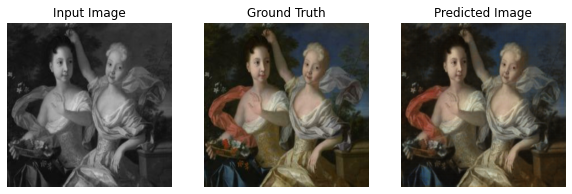

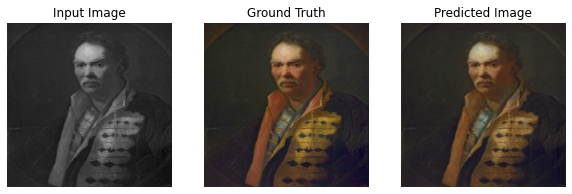

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


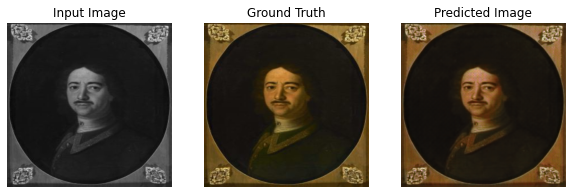

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


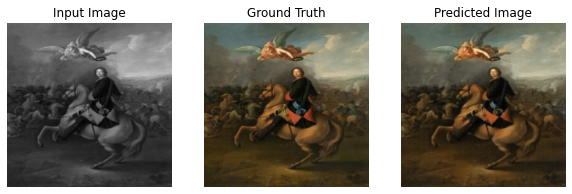

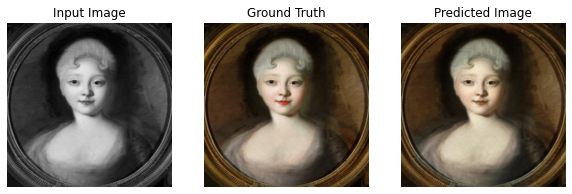

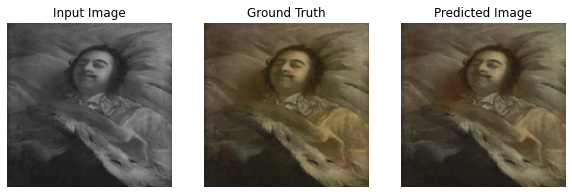

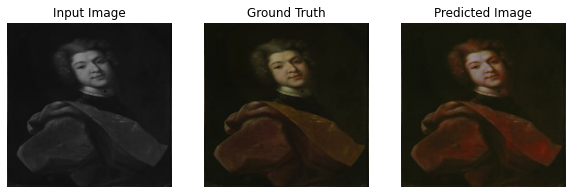

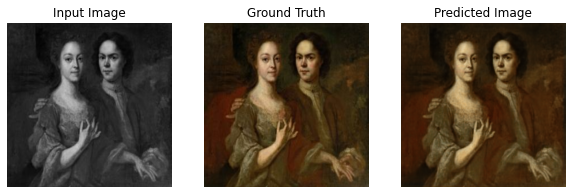

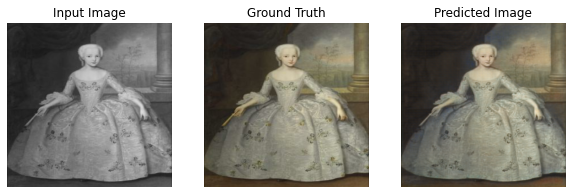

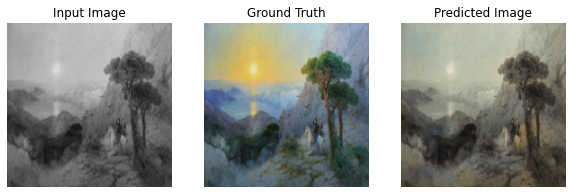

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


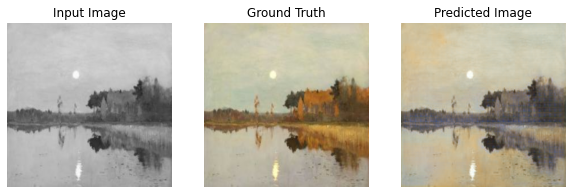

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


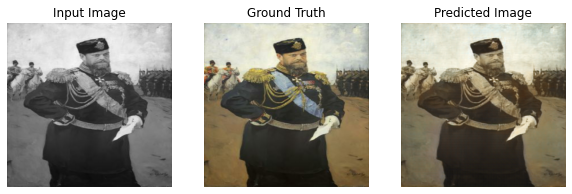

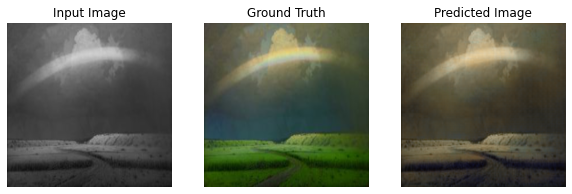

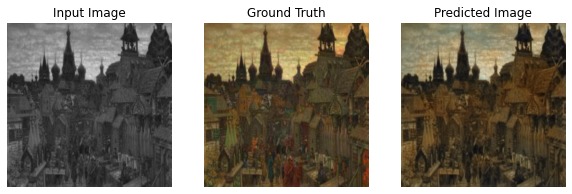

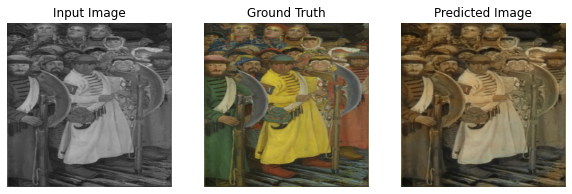

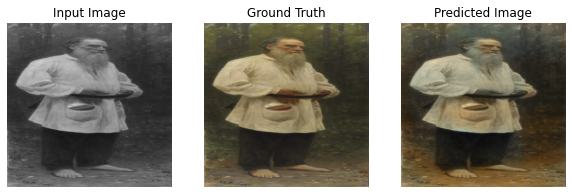

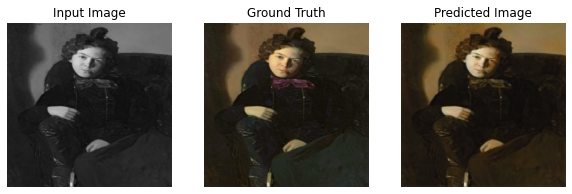

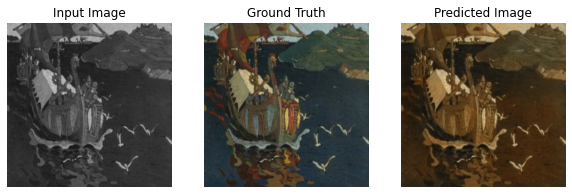

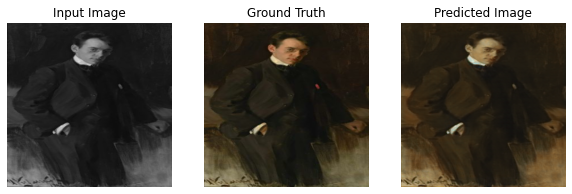

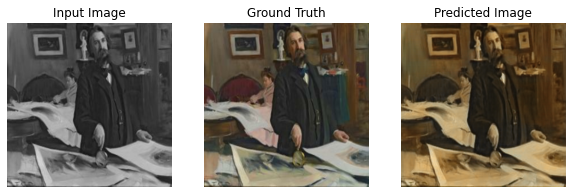

In [ ]:
imgi = 2
for inp, tar in test_dataset.take(20):
  generate_images(generator, inp, tar, str(imgi) + '_' + str(300), display_imgs=True)